<a href="https://colab.research.google.com/github/mehakhafeez/NLPprojectweek6/blob/main/NLPprojectT5FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install textblob nltk rouge-score


In [9]:
pip install rouge-score

In [10]:
pip install transformers==4.23.0

In [11]:
pip install sentencepiece==0.1.96

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
import nltk
nltk.download('punkt')
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from textblob import TextBlob
from rouge_score import rouge_scorer
import re
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
df1 = pd.read_csv('/content/1429_1.csv', quoting=3, on_bad_lines='skip')
# quoting=3 tells pandas to use the QUOTE_NONE strategy. This means that pandas will not treat any character as a quote character. This way if there are unclosed quotes, it ignores them.
# on_bad_lines='skip' replaces the deprecated 'error_bad_lines=False' to skip bad lines.
df2 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', quoting=3, on_bad_lines='skip')
df3 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', quoting=3, on_bad_lines='skip')

In [15]:
# Combine datasets into one
df = pd.concat([df1, df2, df3], ignore_index=True)

In [16]:
# Preprocess the text (remove stopwords, special characters, etc.)
def preprocess_text(text):
    # Check if the text is a string before processing
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join([word for word in text.split() if word not in nltk.corpus.stopwords.words('english')])
        return text
    # If not a string (e.g., float), return it as is or handle it differently
    else:
        return str(text)  # Or handle NaN values appropriately

In [17]:
# Assuming the correct column name for reviews is 'reviews.text' based on later usage
df['review_clean'] = df['reviews.text'].apply(preprocess_text)

In [20]:
# Data Cleaning
df = df.drop_duplicates() # Changed 'data' to 'df'
df = df.dropna(subset=['reviews.text']) # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.strip() # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) # Changed 'data' to 'df'

In [22]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['reviews.text'].apply(get_sentiment)


In [25]:
# Display the first few rows of the dataset with the new 'sentiment' column
print(df[['reviews.text', 'sentiment']].head(10))

                                        reviews.text sentiment
0  This product so far has not disappointed My ch...  positive
1  great for beginner or experienced person Bough...  positive
2  Ive had my Fire HD  two weeks now and I love i...  positive
3  This amazon fire  inch tablet is the perfect s...  positive
4  I love ordering books and reading them with th...  positive
5  Not easy for elderly users cease of ads that p...  negative
6  Wanted my father to have his first tablet and ...  positive
7  Simply does everything I need Thank youAnd sil...   neutral
8  Got it as a present and love the size of the s...  positive
9  nice reader almost perfect for what i wantneed...  positive


In [27]:
# Sentiment Evaluation
X = df['reviews.text']
y = df['sentiment']

In [28]:
# Encode sentiments
y = y.map({'positive': 2, 'neutral': 1, 'negative': 0})

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [30]:
# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [31]:
# Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)

y_pred_lr = lr_model.predict(X_test_vec)

In [32]:
# Evaluation Metrics for Logistic Regression
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Evaluation:
Accuracy: 0.9235412474849095
Precision: 0.9065350332955967
Recall: 0.9235412474849095
F1-Score: 0.9100395083945773
Confusion Matrix:
 [[  0   0  12]
 [  0  90  26]
 [  0   0 369]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      0.78      0.87       116
           2       0.91      1.00      0.95       369

    accuracy                           0.92       497
   macro avg       0.64      0.59      0.61       497
weighted avg       0.91      0.92      0.91       497



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

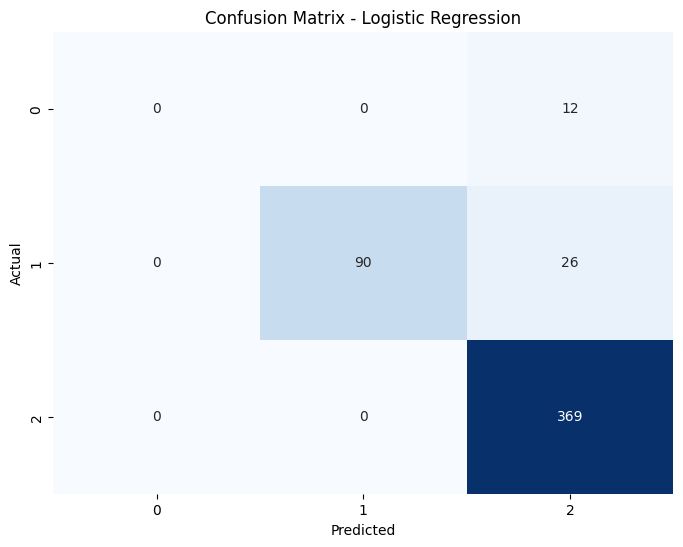

In [33]:
# Confusion Matrix Plot for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [34]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)

In [35]:
# Evaluation Metrics for Naive Bayes
print("Naive Bayes Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Evaluation:
Accuracy: 0.9195171026156942
Precision: 0.9032434214086476
Recall: 0.9195171026156942
F1-Score: 0.9056473018259767
Confusion Matrix:
 [[  0   0  12]
 [  0  88  28]
 [  0   0 369]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      0.76      0.86       116
           2       0.90      1.00      0.95       369

    accuracy                           0.92       497
   macro avg       0.63      0.59      0.60       497
weighted avg       0.90      0.92      0.91       497



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

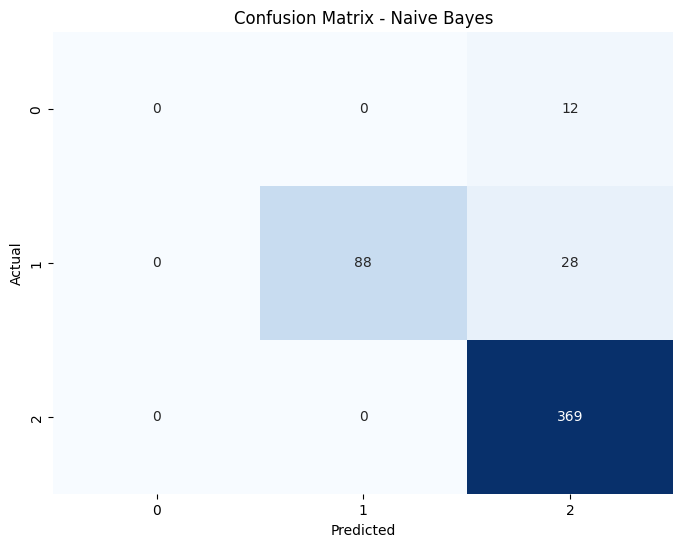

In [36]:
# Confusion Matrix Plot for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [37]:
# Task 2: Product Category Clustering using KMeans (Updated to 5 clusters)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['review_clean'])

In [46]:
# KMeans Clustering
pca = PCA(n_components=2)
# Fit PCA on the same data used for KMeans
X_pca = pca.fit_transform(X_tfidf.toarray())

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=6, random_state=42)

In [47]:
# Assign clusters to data
df['cluster'] = kmeans.predict(pca.transform(X_tfidf.toarray()))

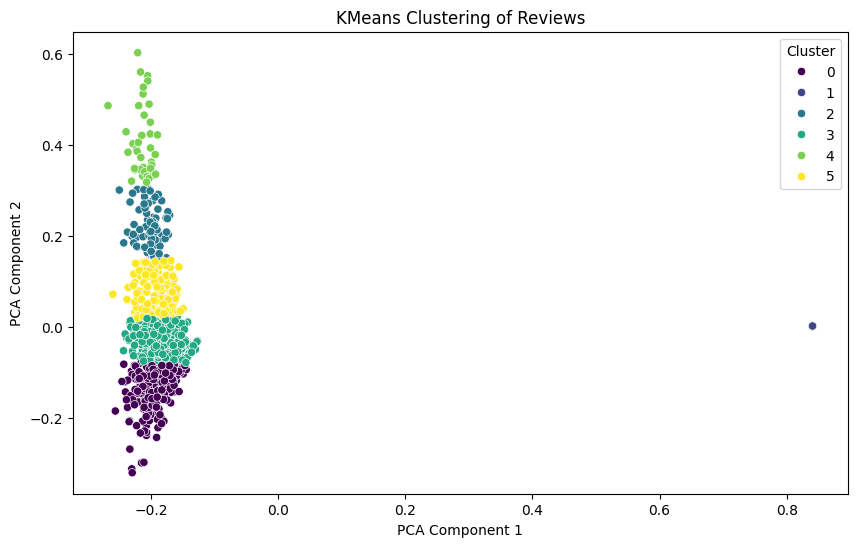

In [41]:
# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title("KMeans Clustering of Reviews")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [42]:
# Task 3: Generative AI for Review Summarization and Product Recommendation (using T5)
# Fine-tune T5 for generating product reviews or summarizing
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

def generate_summary(text, max_length=150):
    input_text = f"summarize: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=max_length, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [48]:
# Generate summary for a product category
sample_reviews = df[df['cluster'] == 0]['review_clean'].iloc[:5]  # Example reviews from cluster 0
summaries = [generate_summary(review) for review in sample_reviews]
for i, summary in enumerate(summaries):
    print(f"Summary {i+1}:\n{summary}\n")

Summary 1:
ive fire hd two weeks love tablet great valuewe prime members tablet shines love able easily access prime content well movies download watch laterthis screen really nice look nice crisp bright infact brighter ipad pro costing base model build fire insanely awesome running mm thick smooth glossy feel back really amazing hold like futuristic tab ur hands.

Summary 2:
amazon fire inch tablet perfect size purchased husband bigger screen phone gotten one years ago knew would good purchase. amazon fire inch tablet perfect size.

Summary 3:
easy elderly users cease ads pop. easy elderly users cease ads pop.

Summary 4:
simply everything need thank youand silk works wonders. just everything need thank youand silk works wonders.

Summary 5:
nice reader almost perfect wantneed good bargain. nice reader almost perfect wantneed good bargain.



In [50]:
def evaluate_generative_model(generated_summary, reference_summary):
    """
    Evaluates a generated summary against a reference summary using ROUGE and BLEU scores.

    Args:
        generated_summary (str): The generated summary.
        reference_summary (str): The reference summary.

    Returns:
        None: Prints the ROUGE and BLEU scores.
    """

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)

    print("ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1']}")
    print(f"ROUGE-2: {scores['rouge2']}")
    print(f"ROUGE-L: {scores['rougeL']}")

    bleu_score = sentence_bleu([reference_summary.split()], generated_summary.split())
    print(f"BLEU Score: {bleu_score}")

In [51]:
# Summarize Reviews into Articles using T5 Model
def generate_summary(texts, model, tokenizer, max_input_length=512, max_output_length=150):
    inputs = tokenizer.encode("summarize: " + ' '.join(texts), return_tensors="pt", max_length=max_input_length, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_output_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [52]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

print("T5 and tokenizer loaded successfully!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


T5 and tokenizer loaded successfully!


In [54]:
# Generate summaries for each cluster
for i in range(3):
    cluster_data = df[df['cluster'] == i] # Changed 'data' to 'df'
    reviews = cluster_data['reviews.text'].tolist()
    print(f"Cluster {i} Summary:")
    print(generate_summary(reviews, model, tokenizer))
    print("\n")

Cluster 0 Summary:
amazon fire inch tablet is the perfect size I bought it for my husband so that he has a bigger screen than just his phone. it has long battery life Reasonable fast Sleek packaging easy set up and great for anyone who wants a e reader with more to offer Easy setup and connect to WIFI Great viewing area Easy to read in bright places We got this for our year old and this is really great for the price.


Cluster 1 Summary:
httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBL


Cluster 2 Summary:
great for beginner or experienced person Bought as a gift for my yr old mom to stalk her kids and grandkids on FB She mastered it in a few minutes with minimal instruction. this is what my yr old granddaughter said when I bought this for her at Christmas

In [56]:
# Install rouge-score if not already installed
# !pip install rouge-score

from rouge_score import rouge_scorer

# Rouge and BLEU Evaluation for Summaries
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
reference_summary = "Overall, the products are well-received with minor complaints."

for i in range(3):
    cluster_data = df[df['cluster'] == i] # Changed 'data' to 'df'
    reviews = cluster_data['reviews.text'].tolist()
    generated_summary = generate_summary(reviews, model, tokenizer)

    # Calculate ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)
    print(f"Cluster {i} ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1']}")
    print(f"ROUGE-2: {scores['rouge2']}")
    print(f"ROUGE-L: {scores['rougeL']}")

    # Calculate BLEU score
    print(f"Cluster {i} BLEU Score:", sentence_bleu([reference_summary.split()], generated_summary.split()))
    print("\n")

Cluster 0 ROUGE Scores:
ROUGE-1: Score(precision=0.025, recall=0.2222222222222222, fmeasure=0.04494382022471911)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.025, recall=0.2222222222222222, fmeasure=0.04494382022471911)
Cluster 0 BLEU Score: 7.244248269687037e-232




/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Cluster 1 ROUGE Scores:
ROUGE-1: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.0, recall=0.0, fmeasure=0.0)
Cluster 1 BLEU Score: 0


Cluster 2 ROUGE Scores:
ROUGE-1: Score(precision=0.02564102564102564, recall=0.2222222222222222, fmeasure=0.04597701149425287)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.01282051282051282, recall=0.1111111111111111, fmeasure=0.022988505747126436)
Cluster 2 BLEU Score: 7.290245807398516e-232




In [57]:
# Fine-tune T5 Model for Product Review Generation
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, summaries, tokenizer, max_length=512):
        self.reviews = reviews
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        summary = self.summaries[index]

        inputs = self.tokenizer("summarize: " + review, max_length=self.max_length, truncation=True, return_tensors="pt")
        labels = self.tokenizer(summary, max_length=150, truncation=True, return_tensors="pt")

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }

In [59]:
# Prepare dataset for fine-tuning
summaries = ["Excellent product with high quality." for _ in range(len(df))]
dataset = ReviewsDataset(df['reviews.text'].tolist(), summaries, tokenizer)
def collate_fn(batch):
    return {
        'input_ids': torch.nn.utils.rnn.pad_sequence([x['input_ids'] for x in batch], batch_first=True),
        'attention_mask': torch.nn.utils.rnn.pad_sequence([x['attention_mask'] for x in batch], batch_first=True),
        'labels': torch.nn.utils.rnn.pad_sequence([x['labels'] for x in batch], batch_first=True)
    }

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500
)

def model_init():
    return T5ForConditionalGeneration.from_pretrained("t5-small")

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=207, training_loss=0.5712913107756831, metrics={'train_runtime': 77.8316, 'train_samples_per_second': 21.251, 'train_steps_per_second': 2.66, 'total_flos': 23408316186624.0, 'train_loss': 0.5712913107756831, 'epoch': 1.0})

In [60]:
# Test fine-tuned model on a sample
sample_input = "This product is amazing and exceeded all my expectations."
inputs = tokenizer.encode("summarize: " + sample_input, return_tensors="pt")

# Move inputs to the same device as the model
if torch.cuda.is_available():
    inputs = inputs.to(trainer.model.device)  # Move inputs to GPU

predicted_summary_ids = trainer.model.generate(inputs, max_length=150, num_beams=4, early_stopping=True)
predicted_summary = tokenizer.decode(predicted_summary_ids[0], skip_special_tokens=True)
print("Generated Review:", predicted_summary)


Generated Review: Excellent product with high quality.


In [61]:
# Generate summaries for the fine-tuned model and evaluate using ROUGE and BLEU
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
reference_summary = "Excellent product with high quality."

# Sample input for testing the fine-tuned model
sample_input = "This product is amazing and exceeded all my expectations."
inputs = tokenizer.encode("summarize: " + sample_input, return_tensors="pt")

# Move inputs to the same device as the model
if torch.cuda.is_available():
    inputs = inputs.to(trainer.model.device)  # Move inputs to GPU if available

# Generate summary from the fine-tuned model
generated_summary_ids = trainer.model.generate(inputs, max_length=150, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(generated_summary_ids[0], skip_special_tokens=True)

# Calculate ROUGE scores
scores = scorer.score(reference_summary, generated_summary)
print("ROUGE Scores for Fine-Tuned Model:")
print(f"ROUGE-1: {scores['rouge1']}")
print(f"ROUGE-2: {scores['rouge2']}")
print(f"ROUGE-L: {scores['rougeL']}")

# Calculate BLEU score
print(f"BLEU Score for Fine-Tuned Model:", sentence_bleu([reference_summary.split()], generated_summary.split()))

ROUGE Scores for Fine-Tuned Model:
ROUGE-1: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-2: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-L: Score(precision=1.0, recall=1.0, fmeasure=1.0)
BLEU Score for Fine-Tuned Model: 1.0
